In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
from scipy import signal
import pickle
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
import random
import tensorflow as tf
import cv2
from scipy import stats



In [2]:
#fix all seeds for random number generators
# Set seed value
seed_value = 9
import os
os.environ['PYTHONHASHSEED']=str(seed_value)# 2. Set `python` built-in pseudo-random generator at a fixed value
random.seed(seed_value)# 3. Set `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)
tf.random.set_seed(seed_value)# 5. Configure a new global `tensorflow` session

# TODO need to add session thing for tensorflow

# Read Depth Camera

In [3]:
# For reading depth camera
def read_depth_camera(dcamera_path, show_video, nw_resize=1, nh_resize=1):
    video  = cv2.VideoCapture(dcamera_path)
    ret, frame = video.read()
    
    # Get total # of frame count 
    frame_count = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
        
    frame_height = int(frame.shape[0])
    frame_width = int(frame.shape[1])

    
    depth_frames = np.empty((frame_count, int(frame_height/nh_resize), int(frame_width/nw_resize)))
    depth_frames = np.empty((frame_count, int(frame_height/nh_resize), int(frame_width/nw_resize),3))
    count = 0
    while (video.isOpened()):
        ret, frame = video.read()
        
        if ret == True:
#             gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            gray_frame = frame/np.maximum(np.max(frame),255)
            gray_frame = cv2.resize(gray_frame, \
                                    (int(frame_width/nw_resize), int(frame_height/nh_resize)),\
                                    interpolation = cv2.INTER_NEAREST)

            depth_frames[count] = gray_frame
            if show_video == True:
                cv2.imshow("Depth", gray_frame)
                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break
            count = count + 1
        else: 
            break
            

    video.release()
    #cv2.destroyAllWindows()
    return depth_frames

In [4]:
def play_video(read_frames):

    for i in range(len(read_frames)):
        # Capture frame-by-frame
        frame = read_frames[i]

        # Display the resulting frame
        plt.imshow(frame)
#         if cv2.waitKey(1) & 0xFF == ord('q'):
#             break
    #cv2.destroyAllWindows()

    return

In [5]:
def show_frame(read_frames, frame_range):
      # Capture frame-by-frame

    # Display the resulting frame
    for i in frame_range:
        fig = plt.figure(figsize=(6,6))        
        a = plt.imshow(read_frames[i])
        
    return

In [6]:
#fix this to concatenate everything
# n_test = 24
# date = '11_15_2020'
# test_str = '/test' + str(n_test)
# #data_dir = r"C:\Users\77bis\Box\CS598 - Final Project\Preliminary Data V4\Test_Subject_Leo" + test_str
# data_dir = "/home/asilador/CS598/CS598-FinalProject/Preliminary Data V4/Test_Subject_Leo" + test_str
# train_dcamera_path = data_dir + '/depth_processed_leo_test'+str(n_test)+'.avi'
# show_video = 0
# n_resize = 1
# x_train = read_depth_camera(train_dcamera_path, show_video, nw_resize=2, nh_resize=3)


n_test = (24,25)
nw_resize = 2
nh_resize = 2
xtemp = {}
show_video = 0
for i in range(len(n_test)):
    test_str = '/test' + str(n_test[i])
    data_dir = "/home/asilador/CS598/CS598-FinalProject/Preliminary Data V5/Test_Subject_Leo" + test_str
    train_dcamera_path = data_dir + '/depth_processed_leo_test'+str(n_test[i])+'.avi'
    x_train = read_depth_camera(train_dcamera_path, show_video, nw_resize=nw_resize, nh_resize=nh_resize)
    xtemp[i]=x_train

In [7]:
x_train.shape

(14668, 60, 80, 3)

In [8]:
tlen = len(xtemp[0])-2 +len(xtemp[1])-2 #remove 2 samples from 24
x_train = np.zeros((tlen,xtemp[0].shape[1],xtemp[0].shape[2],xtemp[0].shape[3]))
x_train[:len(xtemp[0])-2,:,:,:] = xtemp[0][:len(xtemp[0])-2,:,:,:]
x_train[(len(xtemp[0])-2):,:,:,:] = xtemp[1][:len(xtemp[1])-2,:,:,:]

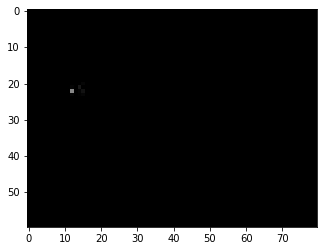

In [9]:
plt.imshow(x_train[-2])


## model.summary()

# read fdss data

In [10]:
#### Removed due to possible syncing/noise issue
# n_test = 24
# date = '11_15_2020'
# test_str = 'test' + str(n_test)
# #data_dir = r"C:\Users\77bis\Box\CS598 - Final Project\Preliminary Data V4\Test_Subject_Leo" + test_str
# data_dir = "/home/asilador/CS598/CS598-FinalProject/Preliminary Data V4/Test_Subject_Leo" + "/" + test_str + "/fcss_processed_leo_" + test_str + "_" + date + ".txt"
# tmpdata = pd.read_csv(data_dir)

In [11]:
# tmpdata.head()

# Read Output Data


In [12]:
def read_output_data(qtm_file_data, theta):
    if theta=='x':
        qtm_data = pd.read_csv(qtm_file_data, usecols = ["Lean Left/Right Angle (deg)"])
    if theta=='y':
        qtm_data = pd.read_csv(qtm_file_data, usecols = ["Lean Forward/Backwards Angle (deg)"])
    if theta=='z':
        qtm_data = pd.read_csv(qtm_file_data, usecols = ["Torso Twist Angle (deg)"])
        
    
    return qtm_data


In [13]:
# n_test = 24
# date = '11_15_2020'
# test_str = '/test' + str(n_test)
# # data_dir = r"C:\Users\77bis\Box\CS598 - Final Project\Preliminary Data V4\Test_Subject_Leo" + test_str
# data_dir = "/home/asilador/CS598/CS598-FinalProject/Preliminary Data V4/Test_Subject_Leo" + test_str
# qtm_file_data_dir = data_dir + '/qtm_processed_leo_test' + str(n_test) + '_' + date + '.txt'
# #show_qtm_plot = True

# y_gt = read_output_data(qtm_file_data_dir,theta_interest).values
# theta_x = read_output_data(qtm_file_data_dir,'x').values
# theta_y = read_output_data(qtm_file_data_dir,'y').values
# theta_z = read_output_data(qtm_file_data_dir,'z').values

n_test = (24,25)
date = ('11_15_2020','11_19_2020')
y_gt = {}
theta_interest = 'z'
for i in range(len(n_test)):
    test_str = '/test' + str(n_test[i])
    data_dir = "/home/asilador/CS598/CS598-FinalProject/Preliminary Data V5/Test_Subject_Leo" + test_str
    qtm_file_data_dir = data_dir + '/qtm_processed_leo_test' + str(n_test[i]) + '_' + date[i] + '.txt'
    y_gttemp = read_output_data(qtm_file_data_dir,theta_interest).values
    y_gt[i]=y_gttemp
    
tlen = len(y_gt[0])-2 +len(y_gt[1])-3 #remove 2 samples from 24 and 3 from 25
y_train = np.zeros((tlen,1))
y_train[:len(y_gt[0])-2] = y_gt[0][:len(y_gt[0])-2]
y_train[(len(y_gt[0])-2):] = y_gt[1][:len(y_gt[1])-3]

In [14]:
y_gt[0].shape

(12751, 1)

In [15]:
# Obtain X and Y data
# x_train.shape
# xtrainnew = pd.DataFrame(data=np.reshape(x_train, (x_train.shape[0],x_train.shape[1]*x_train.shape[2])))
# yframe = pd.DataFrame(data=y_train)

# TheData = pd.concat([xtrainnew,yframe],axis=1) #only contains video data
print(x_train.shape)
print(y_train.shape)

(27415, 60, 80, 3)
(27415, 1)


In [16]:
print(xtemp[0].shape)
print(y_gt[0].shape)
print(xtemp[1].shape)
print(y_gt[1].shape)

(12751, 60, 80, 3)
(12751, 1)
(14668, 60, 80, 3)
(14669, 1)


In [17]:
# xtmp = xtrainnew[300,:]
# plt.imshow(np.reshape(xtmp, (x_train.shape[1],x_train.shape[2])))

In [18]:
nsamps = x_train.shape[0]
n80p = int(np.floor(nsamps*0.8))
rannums = np.array(random.sample(range(1,nsamps,1), n80p))
s_nfiles = np.arange(nsamps)
test_set = np.setdiff1d(s_nfiles,rannums)

#

In [19]:
Trainset = x_train[rannums,:]
Testset = x_train[test_set,:]
# Trainy= y_gt[rannums,:]
# Testy = y_gt[test_set,:]
Trainy= y_train[rannums,:]
Testy = y_train[test_set,:]

In [20]:
sc_y = StandardScaler()

In [21]:
Xtrainz = Trainset
ytrainz = Trainy
X = Xtrainz
y = sc_y.fit_transform(ytrainz)

In [22]:
#make validation data available to model.fit
Xvalid = Testset

y_valid = Testy
y_valid = sc_y.transform(y_valid)


In [23]:
x_train.shape[1]

60

# Regress using Neural Network

In [24]:
np.min(Xvalid) #7min*30fps*60s/min*0.8 ~ 10800

0.0

In [25]:
# Create Neural Netowrk
# model = tf.keras.Sequential()
# model.add(tf.keras.Input(shape=(X.shape[1],)))
# model.add(tf.keras.layers.Dense(200, activation="relu"))
# #model.add(tf.keras.layers.Dropout(0.5))
# model.add(tf.keras.layers.Dense(200, activation="relu"))
# model.add(tf.keras.layers.Dropout(0.5))          
# model.add(tf.keras.layers.Dense(100, activation='linear')) #added extra layer. probably overkill but want good results
# model.add(tf.keras.layers.Dense(1, activation='linear'))
# model.compile(optimizer='adam',
#               loss='mae',
#               metrics=['mse','mae'])
    
# # loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# # loss_fn(y_train[:1], predictions).numpy()

from keras.layers import Bidirectional, Conv2D, MaxPooling2D, Input, Concatenate, AveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Dense, Activation, Dropout, Reshape, Permute, Flatten
from keras.models import Model

model_start = Input(shape=(x_train.shape[1],x_train.shape[2],x_train.shape[3]))
model_cnn = model_start
# f_pool_size = (5,2,2)
dropout_rate = 0.2
# for i, convCnt in enumerate(f_pool_size):
#     model_cnn = Conv2D(filters=x_train.shape[2], kernel_size=(3, 3))(model_cnn)
#     model_cnn = BatchNormalization()(model_cnn)
#     model_cnn = Activation('relu')(model_cnn)
#     model_cnn = MaxPooling2D(pool_size=(f_pool_size[i], f_pool_size[i]))(model_cnn)
#     model_cnn = Dropout(dropout_rate)(model_cnn)

# model_cnn = Conv2D(filters=8, kernel_size=(3, 3),padding='same')(model_cnn)
# # model_cnn = BatchNormalization()(model_cnn)
# model_cnn = Activation('relu')(model_cnn)
# model_cnn = AveragePooling2D(pool_size=(2, 2))(model_cnn)
# # model_cnn = Dropout(dropout_rate)(model_cnn)

model_cnn = Conv2D(filters=16, kernel_size=(3, 3),padding='same')(model_cnn)
# model_cnn = BatchNormalization()(model_cnn)
model_cnn = Activation('relu')(model_cnn)
model_cnn = AveragePooling2D(pool_size=(2, 2))(model_cnn)
# model_cnn = Dropout(dropout_rate)(model_cnn)

model_cnn = Conv2D(filters=32, kernel_size=(3, 3),padding='same')(model_cnn)
# model_cnn = BatchNormalization()(model_cnn)
model_cnn = Activation('relu')(model_cnn)
model_cnn = AveragePooling2D(pool_size=(2, 2))(model_cnn)
# model_cnn = Dropout(dropout_rate)(model_cnn)

model_cnn = Conv2D(filters=64, kernel_size=(3, 3),padding='same')(model_cnn)
# model_cnn = BatchNormalization()(model_cnn)
model_cnn = Activation('relu')(model_cnn)
model_cnn = AveragePooling2D(pool_size=(2, 2))(model_cnn)
# model_cnn = Dropout(dropout_rate)(model_cnn)

model_cnn = Conv2D(filters=96, kernel_size=(3, 3),padding='same')(model_cnn)
# model_cnn = BatchNormalization()(model_cnn)
model_cnn = Activation('relu')(model_cnn)
model_cnn = AveragePooling2D(pool_size=(2, 2))(model_cnn)
# model_cnn = Dropout(dropout_rate)(model_cnn)

model_cnn = Flatten()(model_cnn)
model_cnn = Activation('relu')(model_cnn)
# model_cnn = Dropout(dropout_rate)(model_cnn)

model_cnn = Dense(128)(model_cnn)
model_cnn = Activation('relu')(model_cnn)
model_cnn = Dropout(dropout_rate)(model_cnn)

# model_cnn = Dense(200)(model_cnn)
# model_cnn = Activation('relu')(model_cnn)
# model_cnn = Dropout(dropout_rate)(model_cnn)

output = Dense(1)(model_cnn)
output = Activation('linear', name='thetaz_out')(output)
model = Model(inputs=model_start,outputs=output)
model.compile(optimizer='adam',
              loss='mae',
              metrics=['mse','mae'])


callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50,restore_best_weights=True) #Moving to 1000 patience. 
model.summary()

Using TensorFlow backend.


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 60, 80, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 60, 80, 16)        448       
_________________________________________________________________
activation_1 (Activation)    (None, 60, 80, 16)        0         
_________________________________________________________________
average_pooling2d_1 (Average (None, 30, 40, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 40, 32)        4640      
_________________________________________________________________
activation_2 (Activation)    (None, 30, 40, 32)        0         
_________________________________________________________________
average_pooling2d_2 (Average (None, 15, 20, 32)        0   

In [26]:
epochs = int(30000)
batch_size = 256
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50,restore_best_weights=True)
history = model.fit(X, y,batch_size=batch_size, epochs = epochs,callbacks = [callback],validation_data = (Xvalid, y_valid),verbose=2)

# model.save('depthforcemodel.h5')
#history.save('depthforcehist.h5')

Train on 21932 samples, validate on 5483 samples
Epoch 1/30000
 - 4s - loss: 0.6706 - mse: 0.9561 - mae: 0.6706 - val_loss: 0.6680 - val_mse: 0.9739 - val_mae: 0.6680
Epoch 2/30000
 - 3s - loss: 0.6537 - mse: 0.9167 - mae: 0.6537 - val_loss: 0.6463 - val_mse: 0.9079 - val_mae: 0.6463
Epoch 3/30000
 - 3s - loss: 0.6383 - mse: 0.8694 - mae: 0.6383 - val_loss: 0.6296 - val_mse: 0.8690 - val_mae: 0.6296
Epoch 4/30000
 - 3s - loss: 0.6208 - mse: 0.8296 - mae: 0.6208 - val_loss: 0.6298 - val_mse: 0.8425 - val_mae: 0.6298
Epoch 5/30000
 - 3s - loss: 0.6030 - mse: 0.7897 - mae: 0.6030 - val_loss: 0.6049 - val_mse: 0.8022 - val_mae: 0.6049
Epoch 6/30000
 - 3s - loss: 0.5880 - mse: 0.7579 - mae: 0.5880 - val_loss: 0.5910 - val_mse: 0.7794 - val_mae: 0.5910
Epoch 7/30000
 - 3s - loss: 0.5706 - mse: 0.7237 - mae: 0.5706 - val_loss: 0.5708 - val_mse: 0.7427 - val_mae: 0.5708
Epoch 8/30000
 - 3s - loss: 0.5555 - mse: 0.6939 - mae: 0.5555 - val_loss: 0.5718 - val_mse: 0.7321 - val_mae: 0.5718
Epoch 9

Epoch 70/30000
 - 3s - loss: 0.3032 - mse: 0.2668 - mae: 0.3032 - val_loss: 0.3521 - val_mse: 0.3556 - val_mae: 0.3521
Epoch 71/30000
 - 3s - loss: 0.2992 - mse: 0.2631 - mae: 0.2992 - val_loss: 0.3501 - val_mse: 0.3523 - val_mae: 0.3501
Epoch 72/30000
 - 3s - loss: 0.2998 - mse: 0.2633 - mae: 0.2998 - val_loss: 0.3489 - val_mse: 0.3471 - val_mae: 0.3489
Epoch 73/30000
 - 3s - loss: 0.2977 - mse: 0.2590 - mae: 0.2977 - val_loss: 0.3568 - val_mse: 0.3546 - val_mae: 0.3568
Epoch 74/30000
 - 3s - loss: 0.2972 - mse: 0.2581 - mae: 0.2972 - val_loss: 0.3573 - val_mse: 0.3558 - val_mae: 0.3573
Epoch 75/30000
 - 3s - loss: 0.2971 - mse: 0.2578 - mae: 0.2971 - val_loss: 0.3448 - val_mse: 0.3427 - val_mae: 0.3448
Epoch 76/30000
 - 3s - loss: 0.2978 - mse: 0.2594 - mae: 0.2978 - val_loss: 0.3543 - val_mse: 0.3548 - val_mae: 0.3543
Epoch 77/30000
 - 3s - loss: 0.2944 - mse: 0.2540 - mae: 0.2944 - val_loss: 0.3437 - val_mse: 0.3410 - val_mae: 0.3437
Epoch 78/30000
 - 3s - loss: 0.2898 - mse: 0.248

Epoch 139/30000
 - 3s - loss: 0.2354 - mse: 0.1738 - mae: 0.2354 - val_loss: 0.3167 - val_mse: 0.2952 - val_mae: 0.3167
Epoch 140/30000
 - 3s - loss: 0.2317 - mse: 0.1707 - mae: 0.2317 - val_loss: 0.3122 - val_mse: 0.2903 - val_mae: 0.3122
Epoch 141/30000
 - 3s - loss: 0.2341 - mse: 0.1712 - mae: 0.2341 - val_loss: 0.3213 - val_mse: 0.3005 - val_mae: 0.3213
Epoch 142/30000
 - 3s - loss: 0.2344 - mse: 0.1717 - mae: 0.2344 - val_loss: 0.3138 - val_mse: 0.2941 - val_mae: 0.3138
Epoch 143/30000
 - 3s - loss: 0.2315 - mse: 0.1697 - mae: 0.2315 - val_loss: 0.3171 - val_mse: 0.2979 - val_mae: 0.3171
Epoch 144/30000
 - 3s - loss: 0.2332 - mse: 0.1708 - mae: 0.2332 - val_loss: 0.3183 - val_mse: 0.2965 - val_mae: 0.3183
Epoch 145/30000
 - 3s - loss: 0.2298 - mse: 0.1675 - mae: 0.2298 - val_loss: 0.3160 - val_mse: 0.2947 - val_mae: 0.3160
Epoch 146/30000
 - 3s - loss: 0.2303 - mse: 0.1691 - mae: 0.2303 - val_loss: 0.3148 - val_mse: 0.2889 - val_mae: 0.3148
Epoch 147/30000
 - 3s - loss: 0.2248 - m

Epoch 208/30000
 - 3s - loss: 0.2023 - mse: 0.1322 - mae: 0.2023 - val_loss: 0.2996 - val_mse: 0.2728 - val_mae: 0.2996
Epoch 209/30000
 - 3s - loss: 0.2022 - mse: 0.1334 - mae: 0.2022 - val_loss: 0.2992 - val_mse: 0.2727 - val_mae: 0.2992
Epoch 210/30000
 - 3s - loss: 0.2079 - mse: 0.1386 - mae: 0.2079 - val_loss: 0.3068 - val_mse: 0.2760 - val_mae: 0.3068
Epoch 211/30000
 - 3s - loss: 0.2033 - mse: 0.1355 - mae: 0.2033 - val_loss: 0.3032 - val_mse: 0.2743 - val_mae: 0.3032
Epoch 212/30000
 - 3s - loss: 0.2054 - mse: 0.1363 - mae: 0.2054 - val_loss: 0.2982 - val_mse: 0.2682 - val_mae: 0.2982
Epoch 213/30000
 - 3s - loss: 0.2009 - mse: 0.1317 - mae: 0.2009 - val_loss: 0.3016 - val_mse: 0.2753 - val_mae: 0.3016
Epoch 214/30000
 - 3s - loss: 0.2003 - mse: 0.1321 - mae: 0.2003 - val_loss: 0.2995 - val_mse: 0.2718 - val_mae: 0.2995
Epoch 215/30000
 - 3s - loss: 0.2016 - mse: 0.1343 - mae: 0.2016 - val_loss: 0.3089 - val_mse: 0.2767 - val_mae: 0.3089
Epoch 216/30000
 - 3s - loss: 0.2003 - m

Epoch 277/30000
 - 3s - loss: 0.1845 - mse: 0.1146 - mae: 0.1845 - val_loss: 0.2974 - val_mse: 0.2642 - val_mae: 0.2974
Epoch 278/30000
 - 3s - loss: 0.1856 - mse: 0.1157 - mae: 0.1856 - val_loss: 0.2970 - val_mse: 0.2650 - val_mae: 0.2970
Epoch 279/30000
 - 3s - loss: 0.1857 - mse: 0.1141 - mae: 0.1857 - val_loss: 0.2960 - val_mse: 0.2672 - val_mae: 0.2960
Epoch 280/30000
 - 3s - loss: 0.1863 - mse: 0.1156 - mae: 0.1863 - val_loss: 0.3038 - val_mse: 0.2698 - val_mae: 0.3038
Epoch 281/30000
 - 3s - loss: 0.1848 - mse: 0.1151 - mae: 0.1848 - val_loss: 0.2987 - val_mse: 0.2689 - val_mae: 0.2987
Epoch 282/30000
 - 3s - loss: 0.1869 - mse: 0.1168 - mae: 0.1869 - val_loss: 0.3032 - val_mse: 0.2716 - val_mae: 0.3032
Epoch 283/30000
 - 3s - loss: 0.1850 - mse: 0.1147 - mae: 0.1850 - val_loss: 0.2977 - val_mse: 0.2670 - val_mae: 0.2977
Epoch 284/30000
 - 3s - loss: 0.1834 - mse: 0.1134 - mae: 0.1834 - val_loss: 0.3003 - val_mse: 0.2686 - val_mae: 0.3003
Epoch 285/30000
 - 3s - loss: 0.1853 - m

Epoch 346/30000
 - 3s - loss: 0.1710 - mse: 0.0982 - mae: 0.1710 - val_loss: 0.2929 - val_mse: 0.2547 - val_mae: 0.2929
Epoch 347/30000
 - 3s - loss: 0.1714 - mse: 0.1033 - mae: 0.1714 - val_loss: 0.2944 - val_mse: 0.2563 - val_mae: 0.2944
Epoch 348/30000
 - 3s - loss: 0.1712 - mse: 0.0992 - mae: 0.1712 - val_loss: 0.2951 - val_mse: 0.2593 - val_mae: 0.2951
Epoch 349/30000
 - 3s - loss: 0.1720 - mse: 0.1002 - mae: 0.1720 - val_loss: 0.2918 - val_mse: 0.2587 - val_mae: 0.2918
Epoch 350/30000
 - 3s - loss: 0.1693 - mse: 0.0989 - mae: 0.1693 - val_loss: 0.2967 - val_mse: 0.2593 - val_mae: 0.2967
Epoch 351/30000
 - 3s - loss: 0.1716 - mse: 0.0994 - mae: 0.1716 - val_loss: 0.2935 - val_mse: 0.2583 - val_mae: 0.2935
Epoch 352/30000
 - 3s - loss: 0.1749 - mse: 0.1037 - mae: 0.1749 - val_loss: 0.2929 - val_mse: 0.2571 - val_mae: 0.2929
Epoch 353/30000
 - 3s - loss: 0.1711 - mse: 0.1004 - mae: 0.1711 - val_loss: 0.2966 - val_mse: 0.2554 - val_mae: 0.2966
Epoch 354/30000
 - 3s - loss: 0.1718 - m

Epoch 415/30000
 - 3s - loss: 0.1640 - mse: 0.0935 - mae: 0.1640 - val_loss: 0.2891 - val_mse: 0.2480 - val_mae: 0.2891
Epoch 416/30000
 - 3s - loss: 0.1634 - mse: 0.0911 - mae: 0.1634 - val_loss: 0.2873 - val_mse: 0.2483 - val_mae: 0.2873
Epoch 417/30000
 - 3s - loss: 0.1637 - mse: 0.0931 - mae: 0.1637 - val_loss: 0.2900 - val_mse: 0.2541 - val_mae: 0.2900
Epoch 418/30000
 - 3s - loss: 0.1618 - mse: 0.0911 - mae: 0.1618 - val_loss: 0.2885 - val_mse: 0.2499 - val_mae: 0.2885
Epoch 419/30000
 - 3s - loss: 0.1610 - mse: 0.0904 - mae: 0.1610 - val_loss: 0.2864 - val_mse: 0.2505 - val_mae: 0.2864
Epoch 420/30000
 - 3s - loss: 0.1612 - mse: 0.0911 - mae: 0.1612 - val_loss: 0.3002 - val_mse: 0.2616 - val_mae: 0.3002
Epoch 421/30000
 - 3s - loss: 0.1637 - mse: 0.0894 - mae: 0.1637 - val_loss: 0.2848 - val_mse: 0.2479 - val_mae: 0.2848
Epoch 422/30000
 - 3s - loss: 0.1629 - mse: 0.0896 - mae: 0.1629 - val_loss: 0.2891 - val_mse: 0.2534 - val_mae: 0.2891
Epoch 423/30000
 - 3s - loss: 0.1629 - m

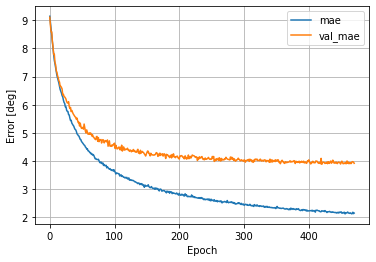

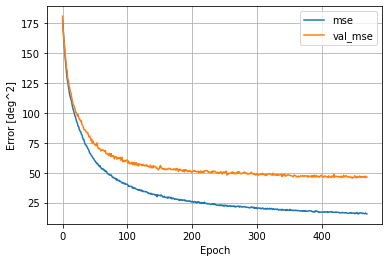

In [31]:
def plot_loss(history):
    
    v1 = history.history['mae']*np.sqrt(sc_y.var_)
    v2 = history.history['val_mae']*np.sqrt(sc_y.var_)
    fig1 = plt.figure()
    ax1 = fig1.add_subplot(111)
    ax1.plot(v1, label='mae')
    ax1.plot(v2, label='val_mae')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Error [deg]')
    ax1.legend()
    ax1.grid(True)
    plt.show()
    
    v3 = history.history['mse']*sc_y.var_
    v4 = history.history['val_mse']*sc_y.var_
    fig2 = plt.figure()
    ax2 = fig2.add_subplot(111)
    ax2.plot(v3, label='mse')
    ax2.plot(v4, label='val_mse')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Error [deg^2]')
    ax2.legend()
    ax2.grid(True)
    plt.show()
    
    
plot_loss(history)


### 4-layer Network: Predict Against Training Data as a Sanity Check

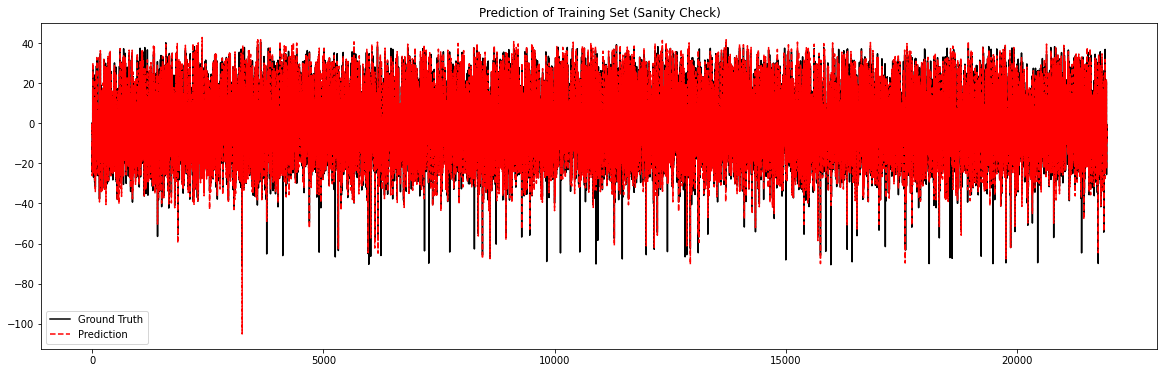

Average error is 0.09 degrees
Root Mean Squared Error is 1.46 degrees
Mean Absolute Error is 1.46 degrees


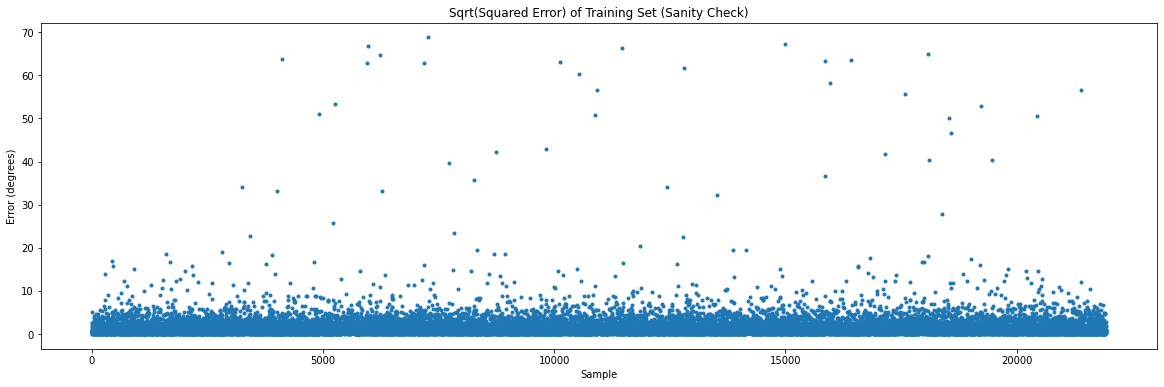

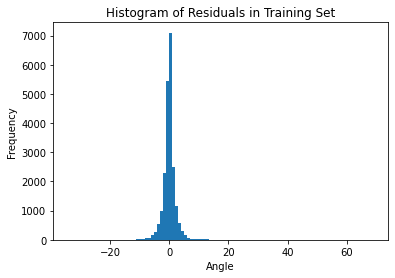

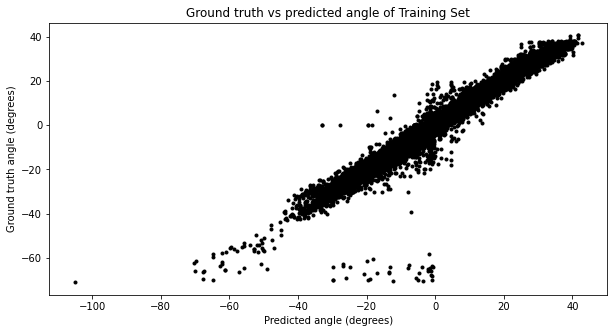

In [32]:

# sanity check with 80% data
Xtrain = Trainset
y_pred = model.predict(Xtrain)
#y_pred = sc_y.inverse_transform(y_pred)
y_pred = sc_y.inverse_transform(y_pred)
y_new = Trainy
plt.figure(figsize=(20,6))
plt.plot(y_new,'k')
plt.plot(y_pred,'r--')
plt.title('Prediction of Training Set (Sanity Check)')
#plt.axis([xmin, xmax, ymin, ymax])
plt.legend(labels=['Ground Truth','Prediction'])
plt.show()
# Squared-root of Squared Error

test_error = (y_pred - y_new)
print('Average error is {:4.2f} degrees'.format(np.sum(test_error)/test_error.shape[0]))
rmse = np.sqrt(test_error**2)
print('Root Mean Squared Error is {:4.2f} degrees'.format(np.sum(rmse)/test_error.shape[0]))
# Mean absolute error
print('Mean Absolute Error is {:4.2f} degrees'.format(np.sum(np.abs(test_error))/test_error.shape[0]))
plt.figure(figsize=(20,6))
plt.plot(rmse,'.')
plt.title('Sqrt(Squared Error) of Training Set (Sanity Check)')
plt.xlabel('Sample')
plt.ylabel('Error (degrees)')
plt.show()

plt.figure()
plt.hist(test_error,bins=100)
plt.title('Histogram of Residuals in Training Set')
plt.xlabel('Angle')
plt.ylabel('Frequency')
plt.show()

#plot scatterplot of data
plt.figure(figsize=(10,5))
plt.scatter(y_pred,y_new,marker='.',color='black')
plt.xlabel('Predicted angle (degrees)')
plt.ylabel('Ground truth angle (degrees)')
plt.title('Ground truth vs predicted angle of Training Set')
plt.show()

### 4-layer Neural Network: Predict Test Set

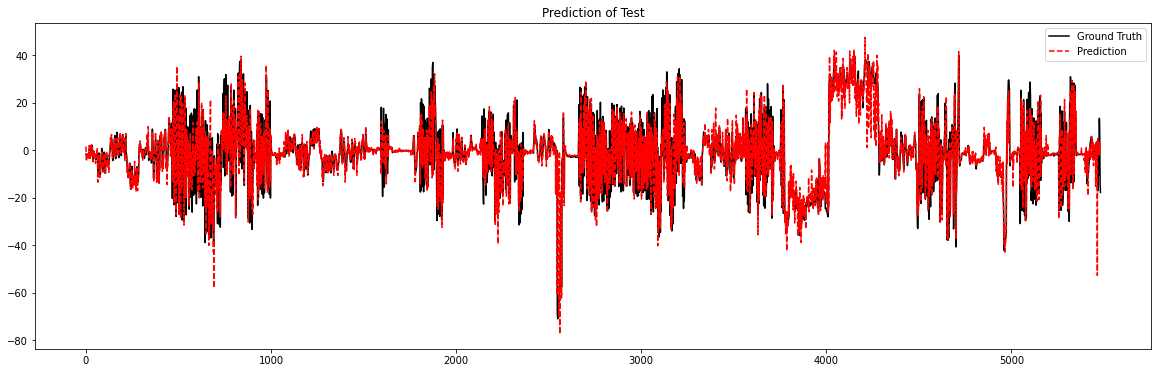

Average error is -0.00 degrees
Root Mean Squared Error is 3.88 degrees
Mean Absolute Error is 3.88 degrees


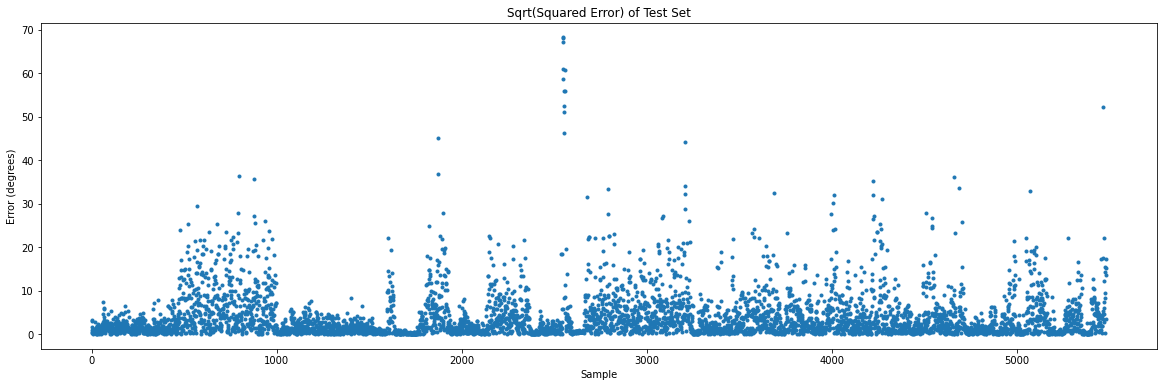

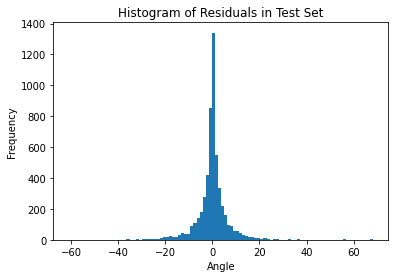

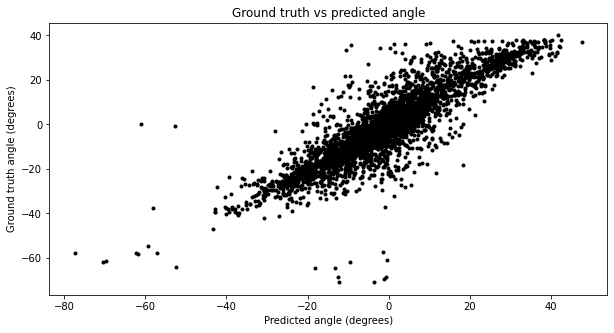

In [33]:
# Redo test set
Xtest = Testset
y_pred = model.predict(Xtest)
#y_pred = sc_y.inverse_transform(y_pred)
y_pred = sc_y.inverse_transform(y_pred)
y_new = Testy

plt.figure(figsize=(20,6))
plt.plot(y_new,'k')
plt.plot(y_pred,'r--')
plt.title('Prediction of Test')
#plt.axis([xmin, xmax, ymin, ymax])
plt.legend(labels=['Ground Truth','Prediction'])
plt.show()

# Squared-root of Squared Error

test_error = (y_pred - y_new)
print('Average error is {:4.2f} degrees'.format(np.sum(test_error)/test_error.shape[0]))
rmse = np.sqrt(test_error**2)
print('Root Mean Squared Error is {:4.2f} degrees'.format(np.sum(rmse)/test_error.shape[0]))
# Mean absolute error
print('Mean Absolute Error is {:4.2f} degrees'.format(np.sum(np.abs(test_error))/test_error.shape[0]))
plt.figure(figsize=(20,6))
plt.plot(rmse,'.')
plt.title('Sqrt(Squared Error) of Test Set')
plt.xlabel('Sample')
plt.ylabel('Error (degrees)')
plt.show()

plt.figure()
plt.hist(test_error,bins=100)
plt.title('Histogram of Residuals in Test Set')
plt.xlabel('Angle')
plt.ylabel('Frequency')
plt.show()

#plot scatterplot of data
plt.figure(figsize=(10,5))
plt.scatter(y_pred,y_new,marker='.',color='black')
plt.xlabel('Predicted angle (degrees)')
plt.ylabel('Ground truth angle (degrees)')
plt.title('Ground truth vs predicted angle')
plt.show()

In [30]:
save_notebookparams = 0
if save_notebookparams:
    pkl_filename = "depthmodelparam_cnn3v10.pkl"
    randata = {}
    randata['nsamps']=nsamps
    randata['n80p']=n80p
    randata['rannums']=rannums
    randata['test_set']=test_set
    modelhistory = history.history
    
    
    with open(pkl_filename, 'wb') as file:
        pickle.dump([randata,sc_y,modelhistory], file)
        
    model.save('depthmodel_cnn3v10.h5') 